<a href="https://colab.research.google.com/github/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3Lina_Jose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrantes: Lina Beltrán (lbeltra1@eafit.edu.co), Jose Muñoz (jjmunozm@eafit.edu.co)

Materia: Alm. & Recu. de información.

Trabajo 3

Universidad EAFIT - Maestria ciencia en datos y analítica

Trabajo 2 Unidad 2 recuperación de texto

Data: https://github.com/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3/twitter.txt

# Abrir archivos desde GitHub

In [1]:
# OJO!!!! Ejecutar este bloque una sola vez (Por cada sesión iniciada en Colab)

!git clone -l -s https://github.com/lmbd92/st1800-st1801-trabajo3-2261.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 177 (delta 113), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (177/177), 40.14 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/cloned-repo
LICENSE    Trabajo3		    twitterClimateData.csv.zip
README.md  Trabajo3Lina_Jose.ipynb


In [ ]:
# Delete repo local colab (Usar solo en caso de requerir actualizar el repo desde Github Nuevamente)

#!rm -r /content/cloned-repo

**Nota:** Para guardar el notebook directamente en Github, dirigirse a File→Save a copy in GitHub

# Preparación de ambiente de trabajo (Dependencias/librerias)

In [4]:
# Modelado y procesamiento NLP
!pip install --upgrade gensim
!pip install nltk

# Interpretar el tema en un modelo de temas que se ha ajustado a un corpus
!pip install pyLDAvis

In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib as plt
# Soporte para expresiones regulares (RE).
import re

In [6]:
# nltk: tokenizador y stopwords

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words_nltk = set(stopwords.words('english'))
print(len(stopwords.words('english')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
179


In [7]:
#Lematizar, Stem
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
#
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [8]:
#imprimir listas grandes
import pprint
from pprint import pprint

# Carga de Data Raw y EDA básico



In [9]:
# Carga de los datos

path_in = '/content/cloned-repo/Trabajo3/'
path_out = '/content/cloned-repo/Trabajo3/out/'
file_name = 'twitterClimateData.csv'

df = pd.read_csv(f'{path_in}{file_name}')
df.head()

,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,...,location,text_clean,tb_sentiment_polarity,tb_sentiment_subjectivity,textBlob_sentiment,vader_compound,vader_pos,vader_neg,vader_neu,V_Sentiment
0,0,1.211810e+18,7.590000e+17,"2020 is the year we #votethemout, the year we ...",15,https://twitter.com/Sphiamia/status/1211807074...,2019-12-31 00:31:35+00:00,Tue Dec 31 00:31:35 +0000 2019,46,NaN,...,"California, USA",2020 is the year we votethemout the year we cl...,-0.100000,0.462500,negative,-0.5682,0.000,0.131,0.869,Negative
1,1,1.210670e+18,2.219547e+07,Winter has not stopped this group of dedicated...,9,https://twitter.com/StephDujarric/status/12106...,2019-12-27 20:56:21+00:00,Fri Dec 27 20:56:21 +0000 2019,35,NaN,...,"California, USA",Winter has not stopped this group of dedicated...,0.000000,0.000000,positive,0.5670,0.215,0.000,0.785,Positive
2,2,1.210590e+18,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,545,https://twitter.com/AlexandriaV2005/status/121...,2019-12-27 15:50:22+00:00,Fri Dec 27 15:50:22 +0000 2019,3283,@UN @Fridays4future,...,"California, USA",WEEK 55 of ClimateStrike at the UN Next week F...,0.166667,0.333333,positive,-0.8567,0.023,0.180,0.797,Negative
3,3,1.210260e+18,1.339821e+09,"A year of resistance, as youth protests shape...",1,https://twitter.com/EnergyHouseVA/status/12102...,2019-12-26 17:53:26+00:00,Thu Dec 26 17:53:26 +0000 2019,2,NaN,...,"California, USA",A year of resistance as youth protests shaped...,0.183333,0.600000,positive,0.7739,0.203,0.051,0.746,Positive
4,4,1.209640e+18,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,1,https://twitter.com/EnergyHouseVA/status/12096...,2019-12-25 00:56:37+00:00,Wed Dec 25 00:56:37 +0000 2019,4,NaN,...,"California, USA",HAPPY HOLIDAYS greta gretathunberg climatecha...,0.650000,0.800000,positive,0.9413,0.451,0.000,0.549,Positive


In [10]:
df.shape

(72405, 24)

In [11]:
df.count()

Unnamed: 0                   72405
id                           72405
author_id                    72405
text                         72405
retweets                     72405
permalink                    72405
date                         72405
formatted_date               72405
favorites                    72405
mentions                     27554
hashtags                     72402
geo                              0
urls                         33349
search_hashtags              72405
location                     72405
text_clean                   72405
tb_sentiment_polarity        72405
tb_sentiment_subjectivity    72405
textBlob_sentiment           72405
vader_compound               72405
vader_pos                    72405
vader_neg                    72405
vader_neu                    72405
V_Sentiment                  72405
dtype: int64

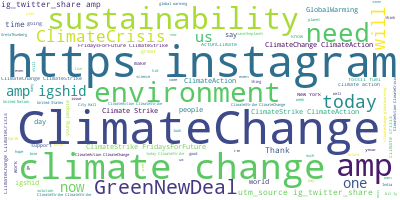

In [12]:
# Importar wordcloud Libreria
from wordcloud import WordCloud
# Unir palabras y caracteres Raw
long_string = ','.join(list(df['text'].values))
# Crear objeto de nube de palabras
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(long_string)
# Visualización
wordcloud.to_image()

# Preparación de data, Nubes de tokens y Frecuencia

Definimos funcion para optimizar incluyendo stem y Lematización

In [13]:
def textprep(line):
    tokens = nltk.word_tokenize(str(line))
    tokens = [w.lower() for w in tokens if len(w)>1]
    tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [w for w in tokens if w not in stop_words_nltk] 
    tokens= [wordnet_lemmatizer.lemmatize(w) for w in tokens]
    tokens= [lancaster.stem(w) for w in tokens]
    return tokens

In [14]:
#Filtramos solo la columna de interés
text_df = df[['text']]
text_df.head()

,text
0,"2020 is the year we #votethemout, the year we ..."
1,Winter has not stopped this group of dedicated...
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...
3,"A year of resistance, as youth protests shape..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...


In [15]:
# creación de columna con tokenización de la columna de interés especifica
text_df['tokens_twitter'] = text_df.apply(lambda row: textprep(row['text']), axis=1)
text_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,tokens_twitter
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ..."
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo..."
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida..."
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec..."


Representación Frecuencia Visual del BoW optimizado

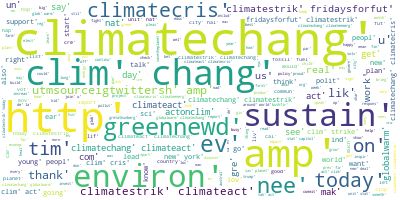

In [16]:
#Convertir Tokens en Lista y Str
tokens_twitter_list=text_df['tokens_twitter'].to_list()
tokens_twitter_str=" ".join([str(item) for item in tokens_twitter_list])
# Crear nube de palabras
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(tokens_twitter_str)
# Visualización
wordcloud.to_image()

# Características y representación

Construir el BoW (diccionario) de términos

In [17]:
# Creación del BoW - en gensim es Dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary(text_df.tokens_twitter)
print(dictionary)

Dictionary(77295 unique tokens: ['2020', '33', 'climatestrik', 'don', 'els']...)


In [18]:
# Bag-of-words representacion de documentos.
corpus = [dictionary.doc2bow(line) for line in text_df.tokens_twitter]

In [19]:
for i in corpus[:10]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]
[(2, 1), (17, 2), (36, 1), (50, 1), (52, 1), (54, 1), (56, 1), (57, 1), (78, 1), (79,

Construir matriz de documentos vs términos

In [20]:
# libreria para paralelizar
#import multiprocessing as mp
#import time

#pool = mp.Pool(mp.cpu_count())
#doc_term_matrix = pool.map(dictionary.doc2bow, [sentence for sentence in text_df.tokens_twitter])
#pool.close()

In [ ]:
#for i in doc_term_matrix[:10]:
#    print(i)

# Modelo no supervisado LDA

In [22]:
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel


Corremos el modelo LDA para valores entre 13 y 17, se evalua y se escoge el correspondiente al accuracy más alto. Para esto se ha utilizado la métrica "Coherence"

In [24]:
for i in range(13,18):
  lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=i, passes=5, alpha='auto')

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model2, texts=text_df['tokens_twitter'], dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('Coherence Score :', coherence_lda)


Coherence Score : 0.38588328606740513
Coherence Score : 0.4013324367120878
Coherence Score : 0.4113238618747143
Coherence Score : 0.37496590426468246
Coherence Score : 0.3650765413241612


De acuerdo a la ejecución anterior el mejor modelo se optiene con un número de Topics **= a 15**

A continuación, se presenta una gráfica que muestra el Score de la métrica Coherence Vs. la cantidad K de tópicos. Este análisis se hizo en el siguiente artículo de Web: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#12buildingthetopicmodel

![picture](https://drive.google.com/uc?export=view&id=11sf_j3B_e9rpuHSrYTEYw2eEyw90-dip)

Podríamos definir una función para nuestro caso y realizar una gráfica similar, pero para efectos académicos y de reducción de recursos computacionales y tiempo, consideraremos el análisis anterior hecho con el ciclo For para valores de K entre 13 y 17 y la gráfica anterior

Con K = 15 y vecinos a 15 se obtienen resultados considerablemente buenos para el Accuracy del modelo, así que en este caso hemos decidido trabajar con **15 Topics**

In [26]:
lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=15, passes=5, alpha='auto')

In [27]:
def assigntopic(doc):
    vector = lda_model2[dictionary.doc2bow(doc)] 
    # opción 1: todos los tópicos ordenados de mayor a menor, podria ser topN tambien asi: return vector[:5] n=5
    #vector = sorted(vector, key=lambda item: -item[1])
    # opción 2: asignar el tópico mayor a cada documento
    vector = max(vector,key=lambda item: item[1])
    return vector

In [28]:
text_df['topics'] = text_df.apply(lambda row: assigntopic(row['tokens_twitter']), axis=1)
text_df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,tokens_twitter,topics
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ...","(5, 0.48799086)"
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo...","(6, 0.28959146)"
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida...","(5, 0.45802212)"
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang...","(6, 0.2608896)"
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec...","(4, 0.1603181)"
5,10 Questions to Ask Politicians About Climate...,"[10, quest, ask, polit, clim, chang, http, www...","(6, 0.2764344)"
6,#climatestrike #FridaysForFuture #portraits #u...,"[climatestrik, fridaysforfut, portrait, unique...","(2, 0.3409106)"
7,#ClimateChangeIsReal #ClimateStrike #ClimateAc...,"[climatechangeisr, climatestrik, climateaction...","(5, 0.22130041)"
8,My oldest daughter finding inspiration and enc...,"[oldest, daught, find, inspir, enco, fut, read...","(5, 0.5253904)"
9,Our toddler #POTUS whined this week about #Tim...,"[toddl, pot, whin, week, tim, magazin, pick, g...","(2, 0.4857746)"


Convertimos la columna **"topics"** en una Lista

In [29]:
topic_list = text_df['topics'].to_list()
print(topic_list)

[(5, 0.48799086), (6, 0.28959146), (5, 0.45802212), (6, 0.2608896), (4, 0.1603181), (6, 0.2764344), (2, 0.3409106), (5, 0.22130041), (5, 0.5253904), (2, 0.4857746), (6, 0.39780903), (8, 0.43535316), (5, 0.24699828), (5, 0.36391395), (6, 0.33335423), (5, 0.28401372), (6, 0.27794972), (5, 0.3005277), (5, 0.28204212), (5, 0.3054526), (5, 0.25789142), (6, 0.3230549), (6, 0.37301883), (5, 0.2864227), (5, 0.276328), (5, 0.39195728), (5, 0.4421774), (5, 0.25853714), (11, 0.21779972), (5, 0.319558), (5, 0.21379277), (6, 0.24783833), (6, 0.31746376), (9, 0.24923024), (6, 0.24058755), (5, 0.23030576), (6, 0.3095413), (5, 0.26715142), (8, 0.1933558), (5, 0.2626758), (6, 0.44101492), (5, 0.4192466), (9, 0.21140385), (5, 0.31656983), (8, 0.30216435), (6, 0.27208862), (5, 0.25023013), (6, 0.3637704), (8, 0.33509642), (6, 0.6339789), (8, 0.4158899), (6, 0.32016796), (5, 0.21987763), (13, 0.35381687), (4, 0.36075458), (6, 0.28296825), (6, 0.22115467), (5, 0.26172504), (8, 0.2883129), (2, 0.5484597), (

Con esto queremos obtener solamente el ID del Topic con mayor probabilidad para cada Documento

In [30]:
topic_id = [i[0] for i in topic_list]
print(topic_id)

[5, 6, 5, 6, 4, 6, 2, 5, 5, 2, 6, 8, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 11, 5, 5, 6, 6, 9, 6, 5, 6, 5, 8, 5, 6, 5, 9, 5, 8, 6, 5, 6, 8, 6, 8, 6, 5, 13, 4, 6, 6, 5, 8, 2, 2, 6, 5, 5, 6, 14, 7, 6, 12, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 8, 8, 12, 5, 5, 9, 9, 9, 6, 5, 5, 6, 5, 9, 9, 8, 9, 9, 8, 5, 6, 5, 5, 5, 5, 8, 5, 0, 5, 6, 5, 14, 5, 5, 8, 6, 5, 5, 5, 7, 8, 5, 6, 5, 6, 6, 8, 5, 5, 5, 6, 6, 5, 5, 5, 6, 13, 5, 6, 5, 5, 6, 6, 6, 5, 5, 8, 5, 1, 5, 5, 6, 9, 5, 8, 6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 12, 10, 5, 5, 5, 5, 6, 5, 6, 12, 6, 6, 5, 5, 6, 5, 5, 8, 6, 5, 6, 5, 6, 6, 6, 5, 5, 5, 6, 10, 5, 5, 6, 8, 12, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 8, 5, 13, 6, 5, 5, 5, 5, 8, 6, 6, 9, 5, 5, 14, 5, 5, 5, 5, 5, 5, 14, 5, 12, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 9, 6, 9, 6, 5, 5, 5, 5, 6, 5, 9, 5, 5, 5, 12, 8, 5, 5, 8, 5, 5, 13, 5, 5, 6, 6, 5, 6, 6, 6, 5, 5, 5, 5, 4, 5, 10, 8, 5, 5, 7, 5, 8, 5, 8, 8, 8, 6, 8, 8, 5, 8, 5, 6, 8, 5, 6, 5, 1, 6, 8, 6, 5, 6, 8, 6, 10, 10, 5, 8, 5, 5, 6, 6, 2, 8, 5, 12, 9,

In [31]:
# Agregamos estos Id al DF
text_df['topic_id'] = topic_id
text_df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,tokens_twitter,topics,topic_id
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ...","(5, 0.48799086)",5
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo...","(6, 0.28959146)",6
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida...","(5, 0.45802212)",5
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang...","(6, 0.2608896)",6
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec...","(4, 0.1603181)",4
5,10 Questions to Ask Politicians About Climate...,"[10, quest, ask, polit, clim, chang, http, www...","(6, 0.2764344)",6
6,#climatestrike #FridaysForFuture #portraits #u...,"[climatestrik, fridaysforfut, portrait, unique...","(2, 0.3409106)",2
7,#ClimateChangeIsReal #ClimateStrike #ClimateAc...,"[climatechangeisr, climatestrik, climateaction...","(5, 0.22130041)",5
8,My oldest daughter finding inspiration and enc...,"[oldest, daught, find, inspir, enco, fut, read...","(5, 0.5253904)",5
9,Our toddler #POTUS whined this week about #Tim...,"[toddl, pot, whin, week, tim, magazin, pick, g...","(2, 0.4857746)",2


Cortamos el DF final para que no colapse Colab con la RAM máxima y nombramos una nueva columna donde estarán los "Destokens" explicado más adelante

In [32]:
# Se crea columna objetivo para almacenar los tokens como texto plano nuevamente sin stopwords
text_df['destokens_twitter']=''
text_df=text_df.head(500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
type(text_df)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               500 non-null    object
 1   tokens_twitter     500 non-null    object
 2   topics             500 non-null    object
 3   topic_id           500 non-null    int64 
 4   destokens_twitter  500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


Loop para poblar la nueva columna 'destokens_twitter'. La columna de tokens ahora se coloca "Destokenizada" porque el modelo en NB no soporta listas

In [34]:
# loop para poblar la nueva columna 'destokens_twitter'

from nltk.tokenize.treebank import TreebankWordDetokenizer
index= len(text_df['tokens_twitter'])
print(index)
for i in range(0,index):
  myListToStr =  TreebankWordDetokenizer().detokenize(text_df.loc[i,'tokens_twitter'])
  text_df.loc[i,'destokens_twitter'] = myListToStr


500


In [35]:
text_df.head(500)

,text,tokens_twitter,topics,topic_id,destokens_twitter
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ...","(5, 0.48799086)",5,2020 year votethemout year climatestrik heart ...
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo...","(6, 0.28959146)",6,wint stop group ded clim act exampl follow cli...
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida...","(5, 0.45802212)",5,week 55 climatestrik un next week fridays4futu...
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang...","(6, 0.2608896)",6,year resist you protest shap clim chang discus...
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec...","(4, 0.1603181)",4,happy holiday gret gretathunberg climatechang ...
...,...,...,...,...,...
495,Wheeled carbon emitting armor machines held up...,"[wheel, carbon, emit, arm, machin, held, nassa...","(5, 0.44811136)",5,wheel carbon emit arm machin held nassau st bl...
496,70% of Americans want climate action. Why has ...,"[70, am, want, clim, act, noth, don, bc, fossi...","(6, 0.3673347)",6,70 am want clim act noth don bc fossil fuel in...
497,It’s fairly safe to say that my protesting pup...,"[fair, saf, say, protest, pup, among, popul, a...","(6, 0.28151307)",6,fair saf say protest pup among popul attend cl...
498,#ClimateStrike DC was giant and full of young ...,"[climatestrik, dc, giant, ful, young, peopl, e...","(5, 0.324493)",5,climatestrik dc giant ful young peopl emot cal...


In [36]:
# Imprimir Keyword en los topics
pprint(lda_model2.print_topics())
doc_lda = lda_model2[corpus]


[(0,
  '0.071*"le" + 0.044*"er" + 0.039*"oc" + 0.035*"sdgs" + 0.029*"sur" + '
  '0.025*"lot" + 0.023*"littl" + 0.023*"conf" + 0.021*"wond" + 0.016*"clear"'),
 (1,
  '0.032*"beauty" + 0.027*"nev" + 0.026*"feel" + 0.026*"pres" + 0.024*"hug" + '
  '0.022*"hard" + 0.022*"est" + 0.020*"not" + 0.018*"thought" + 0.016*"alway"'),
 (2,
  '0.074*"globalwarm" + 0.068*"climateemerg" + 0.048*"climatechangeisr" + '
  '0.037*"climateactionnow" + 0.028*"climatecris" + 0.025*"trump" + '
  '0.023*"fuel" + 0.023*"warm" + 0.021*"project" + 0.021*"fossil"'),
 (3,
  '0.068*"de" + 0.044*"la" + 0.029*"en" + 0.022*"ris" + 0.021*"flood" + '
  '0.020*"level" + 0.020*"et" + 0.018*"sea" + 0.018*"believ" + 0.018*"virgin"'),
 (4,
  '0.086*"nt" + 0.034*"tre" + 0.034*"happy" + 0.031*"plant" + 0.026*"anoth" + '
  '0.023*"sol" + 0.021*"coal" + 0.020*"anim" + 0.018*"hot" + 0.016*"kind"'),
 (5,
  '0.077*"climatechang" + 0.024*"environ" + 0.019*"greennewd" + 0.015*"http" + '
  '0.013*"thank" + 0.013*"nee" + 0.012*"lik" + 0

In [37]:
len(lda_model2.print_topics())

15

Analizando Resultados del LDA 

In [38]:
#from pyLDAvis 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [39]:
# Visualización de topics
pyLDAvis.enable_notebook()

if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model2, corpus, dictionary)
    with open("/content/cloned-repo/Trabajo3/out", 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

with open("/content/cloned-repo/Trabajo3/out", 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/cloned-repo/Trabajo3/out.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.361138 -0.026706       1        1  29.444074
6     -0.336245  0.081786       2        1  19.622833
12    -0.136058 -0.309221       3        1  10.299778
8     -0.115378  0.226708       4        1   8.095728
2     -0.014782 -0.096815       5        1   4.163680
9      0.016095  0.202709       6        1   3.747923
3      0.103851  0.004745       7        1   3.663733
14     0.077015 -0.128096       8        1   3.649823
11     0.073154 -0.043351       9        1   2.964027
10     0.110475  0.006860      10        1   2.905844
13     0.088764  0.029210      11        1   2.860763
4      0.104889  0.006536      12        1   2.615509
0      0.119326  0.023312      13        1   2.321104
1      0.130583  0.015756      14        1   1.999802
7      0.139449  0.006567      15        1   1.645378, topic_info=              Term          Freq         Total Category  logprob  loglift
126                 16996.000000  16996.000000  Default  30.0000  30.0000
2     climatestrik  23301.000000  23301.000000  Default  29.0000  29.0000
88         sustain  18325.000000  18325.000000  Default  28.0000  28.0000
250            amp  12878.000000  12878.000000  Default  27.0000  27.0000
17            clim  15549.000000  15549.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
566          trust    131.242024    132.409824  Topic15  -4.9722   4.0983
493            wan    126.611283    127.779083  Topic15  -5.0081   4.0980
471            gon    269.414644    279.700977  Topic15  -4.2530   4.0697
1195         staff    162.511463    177.205734  Topic15  -4.7585   4.0206
548           publ    534.738899    993.767103  Topic15  -3.5675   3.4875

[621 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
126      10  0.999959              
78        8  0.997383            10
1189      7  0.996493            12
1556     15  0.995452            15
3401     15  0.995010            17
...     ...       ...           ...
1848     12  0.995385  youthforclim
3350     15  0.997329        youtub
3106     11  0.997000          zero
90       10  0.998084      zerowast
2137     10  0.993553           zon

[826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 13, 9, 3, 10, 4, 15, 12, 11, 14, 5, 1, 2, 8])

# Modelo Clasificación NB

Creamos un nuevo DF con las columnas de interés para la aplicación del NAIVE BAYES. En este caso se escoge la columna del BoW Tokenizado Optimizado y la columna de los Topics más relevantes de cada Doc

In [40]:
tokens_topics_df= text_df[['destokens_twitter','topic_id']]
tokens_topics_df.head(10)

,destokens_twitter,topic_id
0,2020 year votethemout year climatestrik heart ...,5
1,wint stop group ded clim act exampl follow cli...,6
2,week 55 climatestrik un next week fridays4futu...,5
3,year resist you protest shap clim chang discus...,6
4,happy holiday gret gretathunberg climatechang ...,4
5,10 quest ask polit clim chang http wwwmomsclea...,6
6,climatestrik fridaysforfut portrait uniquechri...,2
7,climatechangeisr climatestrik climateactionnow,5
8,oldest daught find inspir enco fut read tim pe...,5
9,toddl pot whin week tim magazin pick gretathur...,2


,destokens_twitter
topic_id,
0,2
1,3
2,6
3,2
4,3
5,228
6,125
7,3
8,73


<Figure size 576x432 with 0 Axes>

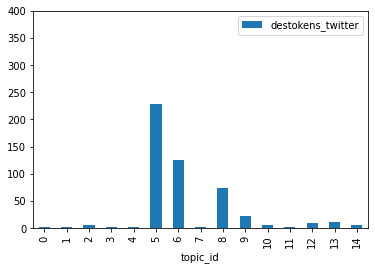

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
tokens_topics_df.groupby('topic_id').count().plot.bar(ylim=0)
plt.ylim(0,400)
tokens_topics_df.groupby('topic_id').count()

Caracterización de los Tokens

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', stop_words='english')
features = tfidf.fit_transform(tokens_topics_df.destokens_twitter).toarray()
labels = tokens_topics_df.topic_id
features.shape

(500, 239)

Modelo NB

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(tokens_topics_df['destokens_twitter'])
encoder = LabelEncoder()
y = encoder.fit_transform(tokens_topics_df['topic_id'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
nb = MultinomialNB()
clf=nb.fit(X_train, y_train)

In [46]:
y_pred=clf.predict(X_test)

In [47]:
len(y_pred)

100

Accuracy

In [48]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.64

f1 Score

In [49]:
# f1 Score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred,average='weighted')

0.6109168375484164

# REFERENCIAS 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://datascienceplus.com/multi-class-text-classification-with-scikit-learn/ 

https://stackoverflow.com/questions/47438313/how-to-predict-after-training-data-using-naive-bayes-with-python